# Data Preprocessing

## Install library

In [1]:
!pip install gdown
!pip install sastrawi
!pip install swifter
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=dda8e12eb8cebd596d996a1422bfecf7c8e4070b466e419ae7f8f16d6e0346f9
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


## Import library

In [10]:
import pandas as pd
import numpy as np
import re
import swifter
import tensorflow as tf
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load dataset

In [3]:
# import news dataset from google drive
!gdown --id 1TZzhtYYXpulrio27rmv-bR_ONo_IQNYz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TZzhtYYXpulrio27rmv-bR_ONo_IQNYz
To: /content/dataset_factual_hoax_news.csv
100% 11.3M/11.3M [00:00<00:00, 81.1MB/s]


In [4]:
df = pd.read_csv("dataset_factual_hoax_news.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7329 entries, 0 to 7328
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       7329 non-null   object
 1   link        7329 non-null   object
 2   date        6722 non-null   object
 3   content     7329 non-null   object
 4   is_fake     7329 non-null   int64 
 5   media_bias  7329 non-null   object
dtypes: int64(1), object(5)
memory usage: 343.7+ KB


## Lemmatization and stopword removal

In [5]:
# create sastrawi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# create sastrawi stopword
stopword_factory = StopWordRemoverFactory()
stopword = stopword_factory.create_stop_word_remover()

In [6]:
# functions for cleaning, removing stopwords
def preprocess_text(text):
    text = str(text)

    # change text to lowercase
    text = text.lower()

    # change link with http/https patterns
    text = re.sub(r'http\S+', '', text)

    # remove hashtag and username
    text = re.sub(r'(@\w+|#\w+)', '', text)

    # remove character other than a-z and A-Z
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # replace new line '\n' with space
    text = re.sub(r'\n', ' ', text)

    # remove stopword with sastrawi library
    text = stopword.remove(text)

    # do stemming with sastrawi library
    text = stemmer.stem(text)

    # removing more than one space
    text = re.sub(r'\s{2,}', ' ', text)

    return text

## Read and process dataset

In [8]:
# read dataset
dataset = pd.read_csv("dataset_factual_hoax_news.csv")
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7329 entries, 0 to 7328
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       7329 non-null   object
 1   link        7329 non-null   object
 2   date        6722 non-null   object
 3   content     7329 non-null   object
 4   is_fake     7329 non-null   int64 
 5   media_bias  7329 non-null   object
dtypes: int64(1), object(5)
memory usage: 343.7+ KB


,title,link,date,content,is_fake,media_bias
0,Epy Kusnandar dan Yogi Gamblez Positif Narkoba,https://megapolitan.kompas.com/read/2024/05/11...,2024-05-11,"JAKARTA, KOMPAS.com - Polisi mengungkap hasil ...",0,netral
1,"Cerita Calon Haji, Rasakan Kemudahan Skrining ...",https://news.detik.com/berita/d-7304275/cerita...,22/04/2024,Salah satu peserta program Jaminan Kesehatan N...,0,netral
2,Polisi: Kami Butuh Partisipasi Warga untuk Ata...,https://megapolitan.kompas.com/read/2024/05/07...,2024-05-07,"JAKARTA, KOMPAS.com - Kapolres Metro Jakarta ...",0,netral
3,Pengunjung Ragunan Tembus 25 Ribu pada Sabtu S...,https://news.detik.com/berita/d-7335065/pengun...,11/05/2024,Sebanyak 25.555 orang tercatat mengunjungi Tam...,0,netral
4,Mensos Beri Santunan ke Ahli Waris Korban Banj...,https://news.detik.com/berita/d-7305239/mensos...,22/04/2024,Menteri Sosial Tri Rismaharini melakukan kunju...,0,netral


In [11]:
# combine title and content
dataset['text'] = dataset['title'] + ' ' + dataset['content']

# text preprocessing
dataset['text'] = dataset['text'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/7329 [00:00<?, ?it/s]

## Save data preprocessing result

In [12]:
# save data preprocessing result
dataset.to_csv("dataset_news.csv")
dataset.to_json("dataset_news.json")

## Create Tokenizer

In [13]:
# separating features and labels
X = dataset['text'].values
y = dataset['is_fake'].values

In [35]:
# Create tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

# Converting text to numeric squences
sequences = tokenizer.texts_to_sequences(X)

# Padding the squences
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post')

## Split the dataset


In [36]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Modeling

## Import library

In [41]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## Create LSTM model

In [53]:
# create model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=200))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    callbacks=[early_stopping])

Epoch 1/10
92/92 [==============================] - 27s 198ms/step - loss: 2.2994 - accuracy: 0.8989 - val_loss: 0.6958 - val_accuracy: 0.9789
Epoch 2/10
92/92 [==============================] - 13s 144ms/step - loss: 0.4065 - accuracy: 0.9719 - val_loss: 0.2668 - val_accuracy: 0.9857
Epoch 3/10
92/92 [==============================] - 12s 125ms/step - loss: 0.1511 - accuracy: 0.9906 - val_loss: 0.0932 - val_accuracy: 0.9939
Epoch 4/10
92/92 [==============================] - 8s 83ms/step - loss: 0.0763 - accuracy: 0.9969 - val_loss: 0.0777 - val_accuracy: 0.9952
Epoch 5/10
92/92 [==============================] - 8s 90ms/step - loss: 0.0745 - accuracy: 0.9956 - val_loss: 0.0524 - val_accuracy: 0.9966
Epoch 6/10
92/92 [==============================] - 6s 66ms/step - loss: 0.0503 - accuracy: 0.9986 - val_loss: 0.0431 - val_accuracy: 0.9973
Epoch 7/10
92/92 [==============================] - 8s 90ms/step - loss: 0.0302 - accuracy: 0.9998 - val_loss: 0.0397 - val_accuracy: 0.9973
Epoch 8

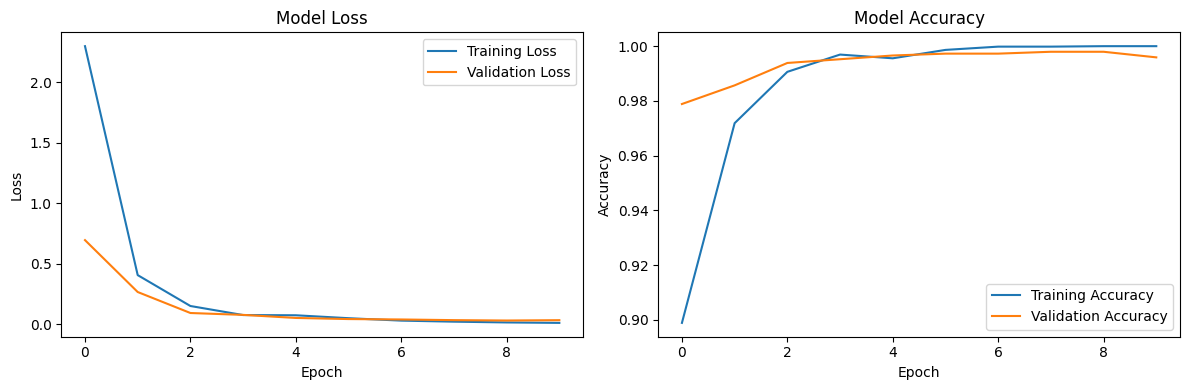

In [54]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Evaluate and save model

In [55]:
import pickle

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save the model with HDF5 format
model.save('hoax_detection_lstm.h5')

# Save the model with pickle format
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

46/46 [==============================] - 1s 15ms/step - loss: 0.0339 - accuracy: 0.9959
Test Accuracy: 99.59%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Convert to TFLite

In [56]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_lstm.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


# Download important files

In [57]:
from google.colab import files
files.download("dataset_news.csv")
files.download("dataset_news.json")
files.download("hoax_detection_lstm.h5")
files.download("hoax_detection_lstm.tflite")
files.download("tokenizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing

In [68]:
import pickle
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

# Memuat Tokenizer dari file Pickle
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Memuat Model TFLite
interpreter = tf.lite.Interpreter(model_path='hoax_detection_lstm.tflite')
interpreter.allocate_tensors()

# Mendapatkan informasi tensor input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Teks baru yang ingin diprediksi
# news_text = ["Ketua Umum Partai Gerindra Prabowo Subianto mempromosikan produk sprei. Dalam video tersebut, Prabowo mengatakan akan membagikan ribuan sprei karena berhasil menang satu putaran dalam Pemilihan Presiden (Pilpres) 2024."]
# news_text = ["JAKARTA, KOMPAS.com - Dewan Kehormatan Penyelenggara Pemilu (DKPP) belum menjadwalkan sidang terhadap aduan soal dugaan perbuatan asusila oleh Ketua KPU RI Hasyim Asy'ari terhadap anggota Panitia Pemilihan Luar Negeri (PPLN) yang bertugas di Eropa.Ketua DKPP Heddy Lugito berujar, kasus itu masih diverifikasi oleh DKPP, tahapan yang memang perlu ditempuh sebelum suatu aduan diregistrasi menjadi perkara yang dibawa ke meja hijau.Sekarang masih dilakukan verifikasi administrasi dan materi. Belum dijadwalkan sidang.Semuanya masih berproses, sebut dia kepada wartawan, Selasa (23/4/2024).Baca juga: Ketua KPU Diadukan Lagi ke DKPP, Diduga Goda Anggota PPLNHeddy menambahkan, bukan hanya kasus Hasyim, sejumlah aduan pelanggaran kode etik dan perilaku penyelenggara pemilu belum dijadwalkan sidang.Penyebabnya, DKPP menerima amat banyak aduan berkaitan dengan pelanggaran kode etik dan perilaku penyelenggara pemilu pada waktu sekitar helatan Pemilu 2024.Selama empat bulan terakhir pengaduan yang masuk ke DKPP jumlah mencapai 200 perkara ucap Heddy.Baru 91 perkara yang dijadwalkan sidang, imbuhnya.Dalam aduan terhadap Hasyim, komisioner KPU RI 2 periode itu disebut menggunakan relasi kuasa untuk mendekati, membina hubungan romantis, dan berbuat asusila.Cerita pertama kali ketemu itu di Agustus 2023, itu sebenarnya juga dalam konteks kunjungan dinas. Itu pertama kali bertemu, hingga terakhir kali peristiwa terjadi di bulan Maret 2024, kata kuasa hukum korban sekaligus pengadu, Maria Dianita Prosperiani, setelah pengaduan ke DKPP.Keduanya disebut beberapa kali bertemu, baik saat Hasyim melakukan kunjungan dinas ke Eropa, atau sebaliknya saat korban melakukan kunjungan dinas ke dalam negeri.Kuasa hukum lainnya, Aristo Pangaribuan, menyebut bahwa dalam keadaan keduanya terpisah jarak, terdapat upaya aktif dari Hasyim secara terus-menerus untuk menjangkau korban.Hubungan romantis, merayu, mendekati untuk nafsu pribadinya, kata Aristo.Namun, menurutnya, tidak ada intimidasi maupun ancaman dalam dugaan pemanfaatan relasi kuasa yang disebut dilakukan oleh Hasyim.Pengacara juga enggan menjawab secara tegas apakah perbuatan asusila yang dimaksud juga mencakup pelecehan seksual atau tidak.Korban disebut butuh waktu untuk mengumpulkan keberanian membuat aduan semacam ini. Pengacara membantah korban memiliki motif politik di balik aduan ini."]
# news_text = ["Beredar sebuah unggahan di media sosial Facebook yang mengeklaim Ketua Umum Partai Gerindra Prabowo Subianto mempromosikan produk sprei. Dalam video tersebut, Prabowo mengatakan akan membagikan ribuan sprei karena berhasil menang satu putaran dalam Pemilihan Presiden (Pilpres) 2024. Faktanya, dilansir dari kompas.com, video yang menampilkan Prabowo sedang memberikan keterangan pers identik dengan yang ada di kanal YouTube Kompas TV. Dalam video aslinya, Prabowo mengucapkan terima kasih ke berbagai pihak yang turut menyukseskan berlangsungnya Debat Pilpres 2024. Menurut Prabowo, adanya debat pilpres merupakan upaya mencari pemikiran dan gagasan yang terbaik untuk Indonesia, meski kadang kala para pasangan calon yang berkompetisi berbeda pendapat."]
news_text = ["Presiden Joko Widodo atau Jokowi mengecam keras serangan Israel ke Kota Rafah, Gaza Selatan, Palestina. Serangan Israel ini menewaskan puluhan warga, termasuk anak-anak. Meskipun sudah berkali-kali saya sampaikan, tapi saya ingin mengulang lagi bahwa Indonesia mengecam keras serangan Israel ke Rafah kata Jokowi di Kota Dumai, Riau, Sabtu (1/6/2024). Dia meminta Israel untuk menataati perintah dari Mahkamah Internasional. Termasuk, menghentikan serangan ke Kota Rafah, Gaza, Palestina. Dan Israel mestinya memiliki kewajiban untuk mentaati mahkamah internasional, termasuk penghentian serangan ke Palestina jelasnya. Sebelumnya, para hakim di pengadilan tinggi PBB atau International Court of Justice (ICJ) memerintahkan Israel untuk menghentikan serangannya di kota Rafah, Gaza selatan. ICJ juga memerintahkan Israel menarik diri dari daerah tersebut. Putusan ini juga terkait dengan tuntutan yang diajukan oleh Afrika Selatan. Afsel menyebut Israel melakukan genosida, dengan alasan risiko besar terhadap penduduk Palestina. Keputusan pada Jumat (24/5/2024) ini menandai ketiga kalinya tahun ini panel beranggotakan 15 hakim itu mengeluarkan perintah awal yang berupaya mengendalikan jumlah korban tewas dan meringankan penderitaan kemanusiaan di Gaza. Meskipun perintah tersebut mengikat secara hukum, pengadilan tidak memiliki polisi untuk menegakkannya, dikutip dari laman Al Jazeera, Jumat (24/5)."]

# Tokenisasi dan padding teks baru
new_sequences = tokenizer.texts_to_sequences(news_text)
max_len = 200  # Pastikan panjang maksimum sesuai dengan yang digunakan saat melatih model
new_padded = pad_sequences(new_sequences, maxlen=max_len)

# Konversi data input menjadi tipe float32
new_padded = new_padded.astype('float32')

# Mengatur tensor input dengan data yang dipadatkan
interpreter.set_tensor(input_details[0]['index'], new_padded)

# Menjalankan interpreter untuk membuat prediksi
interpreter.invoke()

# Mendapatkan hasil prediksi dari tensor output
predictions_tflite = interpreter.get_tensor(output_details[0]['index'])

# Menginterpretasikan hasil prediksi
predicted_labels_tflite = [1 if pred > 0.5 else 0 for pred in predictions_tflite]

# Menampilkan hasil prediksi
for text, pred, label in zip(news_text, predictions_tflite, predicted_labels_tflite):
    print(f'Text: {text}')
    print(f'Prediction: {pred[0]:.4f}')
    print(f'Predicted Label: {"Hoax" if label == 1 else "Not Hoax"}')

Text: Presiden Joko Widodo atau Jokowi mengecam keras serangan Israel ke Kota Rafah, Gaza Selatan, Palestina. Serangan Israel ini menewaskan puluhan warga, termasuk anak-anak. Meskipun sudah berkali-kali saya sampaikan, tapi saya ingin mengulang lagi bahwa Indonesia mengecam keras serangan Israel ke Rafah kata Jokowi di Kota Dumai, Riau, Sabtu (1/6/2024). Dia meminta Israel untuk menataati perintah dari Mahkamah Internasional. Termasuk, menghentikan serangan ke Kota Rafah, Gaza, Palestina. Dan Israel mestinya memiliki kewajiban untuk mentaati mahkamah internasional, termasuk penghentian serangan ke Palestina jelasnya. Sebelumnya, para hakim di pengadilan tinggi PBB atau International Court of Justice (ICJ) memerintahkan Israel untuk menghentikan serangannya di kota Rafah, Gaza selatan. ICJ juga memerintahkan Israel menarik diri dari daerah tersebut. Putusan ini juga terkait dengan tuntutan yang diajukan oleh Afrika Selatan. Afsel menyebut Israel melakukan genosida, dengan alasan risiko